In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
import random
import copy
import seaborn as sns
from Test import *
import math

In [8]:
Seed = 2001  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)


In [9]:
# Graph
required_probability=0.9999
num_nodes, Gx,A,pos,r_c=build_random_graph(2,required_probability,fix_num_nodes=True)
print("num_nodes:",num_nodes)

percentageCorrupt = 0    #Percentage of corrupt clients
corrupt = True              #If True, corrupt clients are included
CorruptClients = CorruptGeneration(percentageCorrupt, corrupt, num_nodes) #Selection of Corrupt Clients

tolerance=-1                #PDMM tolerance
c=1                       #PDMM c
max_iters=13             #PDMM max iterations (not transmissions)

var = 30000                  # Standard deviation for Gaussian noise
mean = 200                    # Mean for Gaussian noise
Target = np.random.randint(1, num_nodes) # Target client for copycat attack
scale = 1
typeAttack = 1              # 0: No attack, 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack

# Data
Data = np.zeros([num_nodes,1])
RealMean = 25
RealVar = 5
# for i in range(num_nodes):
#     Data[i] = np.random.normal(RealMean, np.sqrt(RealVar))

Data[0] = 10
Data[1] = 20

G = nx.Graph()
G.add_nodes_from([0, 1])
G.add_edge(0, 1)

A_ij = calc_incidence_nested(G)
print(A_ij)

num_nodes: 2
IteNumber of Corrupt nodesration 0, Corrupt nodes: []
{0: {1: 1}, 1: {0: -1}}


In [10]:
def main():
    Error = []

    Error, Transmission,avg_temp = PDMM(Data, G, 15, tolerance, c, max_iters)
    print(avg_temp)
    
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(Error)), Error, label='PDMM convergenc')
    plt.yscale('log')
    plt.title('PDMM erorr over tranmission rounds')
    plt.xlabel('Transmission Round')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.tight_layout()
    plt.show()

In [11]:
def PDMM( Data, G, avg_temp, tolerance, c, max_iters):

    num_nodes = G.number_of_nodes()
    x=np.zeros([num_nodes,1])
    converged = False
    Error = np.array([])
    #initialise A_ij
    A_ij=calc_incidence_nested(G)
    #initialise z_ij and y_ij
    z = np.zeros((num_nodes, num_nodes))
    y = np.zeros((num_nodes, num_nodes))

    for i in np.arange(0,num_nodes):
        for j in G.neighbors(i):
            z[i][j]=0
            y[i][j]=0
    node_list = list(range(num_nodes))
    count=1
    while not converged and count < max_iters:
        #update x_i and y_ij
        #i = np.random.randint(0, num_nodes)
        
        i = node_list[count % num_nodes]
        print(f"This is node {i}")
        #update x_i
        x[i]=Data[i]
        for j in G.neighbors(i):
            x[i]=x[i]-A_ij[i][j]*z[i][j]
        x[i]=x[i]/(1+c*G.degree(i))
        print(f"x = {x[i]}")
        #update y_ij
        for j in G.neighbors(i):
            y[i][j]=z[i][j]+2*c*(x[i]*A_ij[i][j])
            print(f"y = {y[i][j]} for neighbour {j}")
        count = count + 1

        diff = x - avg_temp
        Error = np.append(Error, np.linalg.norm(diff))
        if np.linalg.norm(diff)< tolerance:
            print(f'Iteration {count}, Norm of difference: {Error:.8f}')
            converged = True
    
        for j in G.neighbors(i):
            z[i][j]=y[j][i]
            print(f"z = {z[i][j]} for neighbour {j}")

    plt.figure(figsize=(10, 6))
    sns.heatmap(z, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
    plt.title('PDMM z Heatmap over Nodes Rounds')
    plt.xlabel('Nodes')
    plt.ylabel('Nodes')
    plt.tight_layout()
    plt.show()

    return Error,count,avg_temp

This is node 1
x = [10.]
y = -20.0 for neighbour 0
z = 0.0 for neighbour 0
This is node 0
x = [5.]
y = 10.0 for neighbour 1
z = -20.0 for neighbour 1
This is node 1
x = [10.]
y = -20.0 for neighbour 0
z = 10.0 for neighbour 0
This is node 0
x = [15.]
y = 10.0 for neighbour 1
z = -20.0 for neighbour 1
This is node 1
x = [15.]
y = -20.0 for neighbour 0
z = 10.0 for neighbour 0
This is node 0
x = [15.]
y = 10.0 for neighbour 1
z = -20.0 for neighbour 1
This is node 1
x = [15.]
y = -20.0 for neighbour 0
z = 10.0 for neighbour 0
This is node 0
x = [15.]
y = 10.0 for neighbour 1
z = -20.0 for neighbour 1
This is node 1
x = [15.]
y = -20.0 for neighbour 0
z = 10.0 for neighbour 0
This is node 0
x = [15.]
y = 10.0 for neighbour 1
z = -20.0 for neighbour 1
This is node 1
x = [15.]
y = -20.0 for neighbour 0
z = 10.0 for neighbour 0
This is node 0
x = [15.]
y = 10.0 for neighbour 1
z = -20.0 for neighbour 1


C:\Users\za_re\AppData\Local\Temp\ipykernel_11624\3625025250.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i][j]=z[i][j]+2*c*(x[i]*A_ij[i][j])


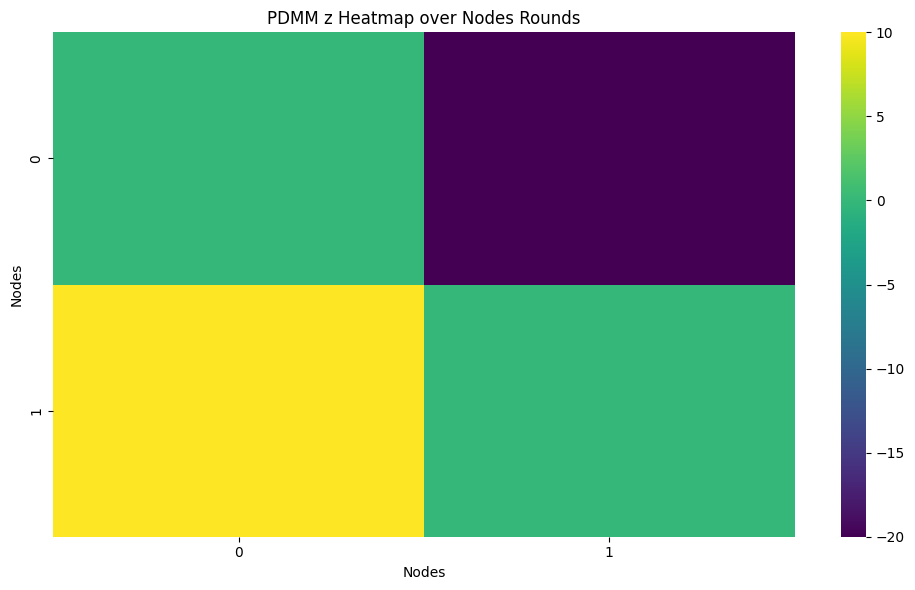

15


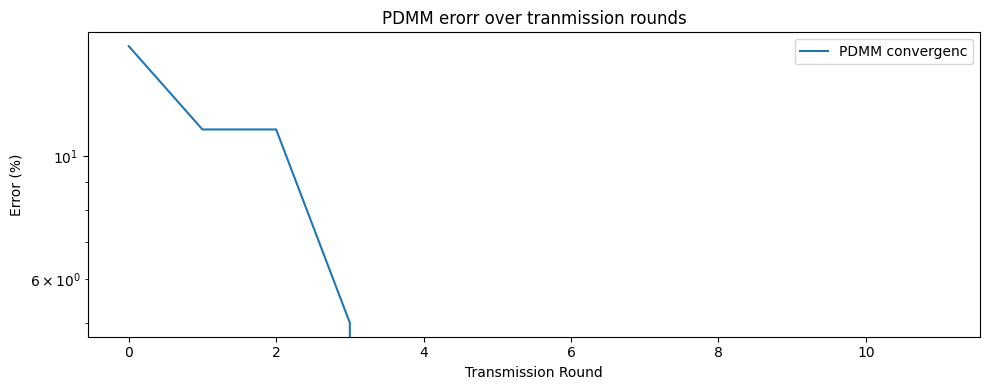

In [12]:
if __name__ == '__main__':
    main()